# Overview of EISPAC

The EIS Python Analysis Code (EISPAC) is developed at the US Naval Research Laboratory and was first released to the public in the spring of 2021. Currently, the code is only available on GitHub at https://github.com/USNavalResearchLaboratory/eispac

### Three main subcomponents
1. An archive of Level-1 data files. These files are saved in the HDF5 file format and come in pairs of header and data files. The archive is updated regularly and can be found at https://eis.nrl.navy.mil/
2. A set of GUI and command line tools (for rapidly searching, downloading, and batch processing data)
3. The Python package itself (includes the GUI and command line tools)

### What Can EISPAC Do?
* Search and download EIS observations
* Explore data contents
* Fit spectral line using multigaussian fit templates
* Compute measurements (intensities, velocities, line widths)
* Generate Sunpy Maps of the fit measurements

# A Quick Primer on EIS Observations

The EUV Imaging Spectrometer (EIS) is a rastering, slit spectrometer on board the Hinode spacecraft. EIS observes spectral lines in two broad EUV wavelength bands, 170 – 210 Å and 250 – 290 Å. However, it is not practical to observe the enterity of these bands at all times; therefore EIS observations are typically collected in descrete spectral "windows" containing a smaller wavelength range centered on select lines of interest. These windows can vary depending on the particular study and a single EIS observation can contain up to 25 windows.

The EIS has two basic modes of operation, "scan" and "sit-and-stare". The EIS slit is always oriented in along the Solar-Y (north-south) axis. As a consequence, scan positions are always stepped along the Solar-X (east-west) axis, starting at the western edge of the obvserved region and proceeding towards the solar east limb.


# Downloading Data

The easiest way to search and download the processed HDF5 files is to use the "eis_catalog" GUI tool included with EISPAC. Once eispac is installed, just use the command `eis_catalog` in your terminal. The code will automatically locate or download a copy of the EIS "as-run" database and then open a program window containing a host of search and filter options.

Alterntively, you can browse and download files directly from the archive via your web browser or use the `eispac.download.download_hdf5_data()` function (assuming you know the exact name of the file you want).

**Coming Soon:** a handy client for Sunpy's Fido data interface will be added to EISPAC very soon. Initially, this client will be limited to time-based searches only.

# A Simple Example

In [1]:
import matplotlib.pyplot as plt
import eispac

if __name__ == '__main__':
    # NB: The "name guard" above is important for running safe, parallel fitting 
    #     in a stand-alone script. If running in an interactive shell, eispac will 
    #     default to a single core. If you _really_ know what you are doing, 
    #     you can override it. Just be careful.
    
    # Select local files (relative paths are fine)
    eis_filepath = './eis_20210424_041423.data.h5'
    template_filepath = './fe_12_195_119.2c.template.h5'
    
    # Load the data and fit template
    # Note: read_cube() performs basic pointing corrections and 
    #       applies the pre-flight radiometric calibration
    data_cube = eispac.read_cube(eis_filepath, window=195.119)
    tmplt = eispac.read_template(template_filepath)

    # Fit the spectra
    fit_res = eispac.fit_spectra(data_cube, tmplt, ncpu='max', unsafe_mp=True)
    
    # Save the full fit results and export select measurements to FITS files
    result_files = eispac.save_fit(fit_res, save_dir='cwd')
    FITS_files = eispac.export_fits(fit_res, save_dir='cwd')

Data file,
   C:\Users\mweberg\Research\Projects\EIS_Python_Code\tutorial\eis_20210424_041423.data.h5
Header file,
   C:\Users\mweberg\Research\Projects\EIS_Python_Code\tutorial\eis_20210424_041423.head.h5
Found a wavelength 195.12 [Angstroms] in window 3
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
CRITICAL WARNING: unsafe_mp == True while no name guard was found in the top-level script! Be aware, parallel processes may freeze or behave unexpectedly.
 + computing fits for 123 exposures, each with 512 spectra
 + running mpfit on 8 cores (of 8)


Finished computing fits!
   runtime : 0:01:47.167497
   62976 spectra fit without issues
   0 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
Saving EIS fit results...
   Directory: C:\Users\mweberg\Research\Projects\EIS_Python_Code\tutorial
   Filenames: eis_20210424_041423.fe_12_195_119.2c-0.fit.h5
              eis_20210424_041423.fe_12_195_179.2c-1.fit.h5
Saving fit EIS inte

# Exploring the Data

`eispac.read_cube()` loads EIS data from a single spectral window (given as either a window index number or wavelength value in units of [Angstrom]). The data is loaded into a coordinate-aware `EISCube` object, which is a subclass of the Sunpy-affiliated `NDCube`. NDCubes have a lot of useful features for manipulating coordinate axes and slicing data. We highly recommended taking a look at the `NDCube` documentation at https://docs.sunpy.org/projects/ndcube/en/stable/

`EISCube` objects have a few EIS-specific properties to make our lives easier,
* `.wavelength` attribute array containing the corrected wavelength values at all locations in image
* `.sum_spectra()` method for summing the data along the wavelength axis
* **Advanced users:** the `.remove_radcal()` and `.apply_radcal()` methods can be used to apply custom calibration curves

Slicing an `EISCube` will automatically slice all the associated subarrays (data, uncertainity, wavelength, and wcs) at the same time.

In [2]:
import astropy.units as u

# Slice the array by indices or crop by coordinates
# Note: the data array axes are in the order of (Y, X, Wavelength)
data_slice = data_cube[0:20, 40:50, :]
lower_left_coords = [-360*u.arcsec, -415*u.arcsec, 195.0*u.angstrom]
upper_right_coords = [-200*u.arcsec, -220*u.arcsec, 195.3*u.angstrom]
data_cutout = data_cube.crop_by_coords(lower_left_coords, upper_corner=upper_right_coords)

# Print the array dimensions and basic WCS info
# Notice how the wcs array axes are reversed relative to the data array
print('data dimensions: ', data_cube.dimensions)
print('slice dimensions:', data_slice.dimensions)
print('cutout dimensions:', data_cutout.dimensions)
print('\n', data_cube) 

data dimensions:  [512. 123.  24.] pix
slice dimensions: [20. 10. 24.] pix
cutout dimensions: [162.  51.  16.] pix

 NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'Wavelength'  'HPLN-TAN'  'HPLT-TAN'  
CRVAL : 194.8543150341613  -0.18142070598072477  -0.14293692694769966  
CRPIX : 1.0  1.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : 0.02228414284752489  0.0011093333032396106  0.0002777777777777778  
NAXIS : 24  123  512
---------------------
Length of NDCube: [512. 123.  24.] pix
Axis Types of NDCube: ('custom:pos.helioprojective.lat', 'custom:pos.helioprojective.lon', 'em.wl')


### Quick-look plots

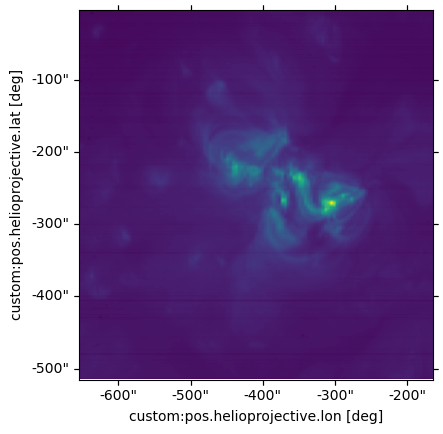

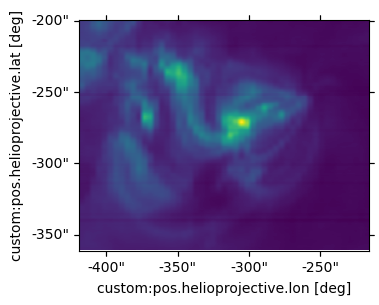

In [3]:
import matplotlib.pyplot as plt

# Data summed along the spectral axis
data_cube.sum_spectra().plot(aspect=data_cube.meta['aspect_ratio'])

plt.figure(figsize=(5,3))
data_cutout.sum_spectra().plot(aspect=data_cutout.meta['aspect_ratio'])
plt.show()

### Checking the metadata
`EISCube.meta` contains all of the information contained in the header file.

In [4]:
# Viewing metadata dictionary keys
for key in data_cube.meta.keys():
    print(key)

filename_data
filename_head
wininfo
iwin
iwin_str
index
pointing
wave
radcal
slit_width
slit_width_units
ccd_offset
wave_corr
wave_corr_t
wave_corr_tilt
date_obs
date_obs_format
duration
duration_units
mod_index
aspect_ratio
extent_arcsec
notes


Of particular note, `.meta['index']` contains information from the original EIS Level-0 FITS file while `.meta['mod_index']` contains a reduced, modified FITS header with all of the pointing information corrected and updated.

In [5]:
print('(X, Y) reference pixel values in [arcsec]')
print('Level-0 (WRONG):', data_cube.meta['index']['crval1'], data_cube.meta['index']['crval2'])
print('Updated (CORRECT):', data_cube.meta['mod_index']['crval1'], data_cube.meta['mod_index']['crval2'])

(X, Y) reference pixel values in [arcsec]
Level-0 (WRONG): -185.176 -523.2
Updated (CORRECT): -653.1145415306091 -514.5729370117188


In [6]:
# View basic information about all spectral windows in the source file
data_cube.meta['wininfo']

rec.array([( 0, 'Fe X 184.530', 184.27106, 184.78386, 24,  851),
           ( 1, 'Fe VIII 185.210', 184.93993, 185.45273, 24,  881),
           ( 2, 'Fe IX 188.350', 187.99422, 188.68526, 32, 1018),
           ( 3, 'Fe XII 195.120', 194.85902, 195.37155, 24, 1326),
           ( 4, 'Fe XIII 202.040', 201.76598, 202.27834, 24, 1636),
           ( 5, 'Fe XIII 203.820', 203.54802, 204.06033, 24, 1716),
           ( 6, 'Si X 258.370', 258.10507, 258.61713, 24, 2746),
           ( 7, 'Fe XVI 262.980', 262.71295, 263.22485, 24, 2953),
           ( 8, 'S X 264.220', 263.95932, 264.47122, 24, 3009),
           ( 9, 'Fe XIV 264.780', 264.51572, 265.0276 , 24, 3034),
           (10, 'Fe XV 284.160', 283.89   , 284.40134, 24, 3905)],
          dtype=[('iwin', '<i4'), ('line_id', '<U64'), ('wvl_min', '<f4'), ('wvl_max', '<f4'), ('nl', '<i4'), ('xs', '<i4')])

### Fit templates and results
The fit templates included with EISPAC consist of one (or more) component Gaussian functions and a contanst background term. Initial parameters and constraintes have been pre-selected based on representitive spectra. Over 119 templates are provided with EISPAC, covering all of the commonly observed spectral lines.

In [7]:
# View template parameters and constraints
print(tmplt)

--- FIT TEMPLATE PARAMETER CONSTRAINTS ---
   *            Value      Fixed            Limited                 Limits               Tied
  p[0]     57514.6647          0          1          0       0.0000       0.0000                   
  p[1]       195.1179          0          1          1     195.0778     195.1581                   
  p[2]         0.0289          0          1          1       0.0191       0.0510                   
  p[3]      8013.4013          0          1          0       0.0000       0.0000                   
  p[4]       195.1779          0          1          1     195.1378     195.2181          p[1]+0.06
  p[5]         0.0289          0          1          1       0.0191       0.0510          p[2]     
  p[6]       664.3349          0          0          0       0.0000       0.0000                   


`eispac.fit_spectra()` takes an `EISCube` and fit template and automatically fits all spectra using a Python version of the venerable `MPFIT` package (using parallel processing, if possible). The output is an `EISFitResult` object, which contains all of the fit parameters, status codes, chi^2 values, and so forth. This may be saved to an HDF5 file and read back in later using the `eispac.save_fit()` and `eispac.read_fit()` functions (as shown in the example above). The actual fit results and parameters are stored in a dictionary of arrays.

In [8]:
for key in fit_res.fit.keys():
    print(f"{key:<15} {fit_res.fit[key].dtype} {fit_res.fit[key].shape}")

line_ids        <U14 (2,)
main_component  int16 ()
n_gauss         int16 ()
n_poly          int16 ()
wave_range      float64 (2,)
status          float64 (512, 123)
chi2            float64 (512, 123)
mask            int32 (512, 123, 24)
wavelength      float64 (512, 123, 24)
int             float64 (512, 123, 2)
err_int         float64 (512, 123, 2)
vel             float64 (512, 123, 2)
err_vel         float64 (512, 123, 2)
params          float64 (512, 123, 7)
perror          float64 (512, 123, 7)
component       int32 (7,)
param_names     <U32 (7,)
param_units     <U32 (7,)


### Extracting and plotting a single spectrum
We can also extract an array of the fit parameters or intensity profile using the `EISFitResult.get_params()` and `.get_fit_profile()` methods. Both methods take optional keywords for selecting the component number and/or an individual pixel (using array coordinates). `.get_fit_profile()` also has a `num_wavelengths` keywords that allows us to interpolate the fit profile at a higher wavelength resolution than observed by EIS.

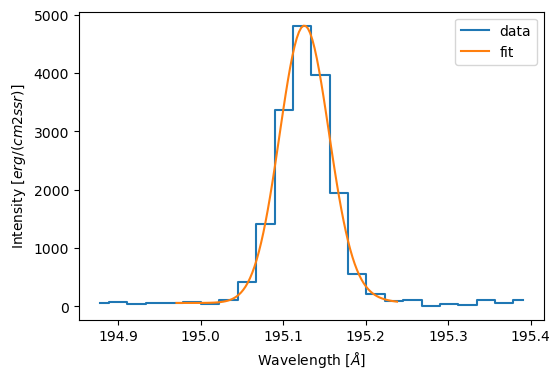

In [9]:
# Select a single point to plot
ex_point = [128, 64] # [Y,X] array coordinates
data_wave = data_cube.wavelength[ex_point[0], ex_point[1], :]
data_inten = data_cube.data[ex_point[0], ex_point[1], :]
fit_wave, fit_inten = fit_res.get_fit_profile(coords=ex_point, num_wavelengths=100)

# Plot the profile and the fit
fig = plt.figure(figsize=(6,4))
plt.step(data_wave, data_inten, where='mid', label='data')
plt.plot(fit_wave, fit_inten, label='fit')
plt.ylabel('Intensity [$'+str(data_cube.unit)+'$]')
plt.xlabel('Wavelength [$\AA}$]')
plt.legend()
plt.show()

# EISMaps for Sunpy

The fit line intensities, velocities, and widths can be loaded into an `EISMap`, which is a subclass of `sunpy.map.Map`. This allow us to leverage the full power of Sunpy to do all sorts of cool science like comparing spacecraft locations, co-alinging images, reprojecting maps, and performing field extrapolations (see the Sunpy tutorial for examples of these tasks and more). You can get an `EISMap` by either using the `EISFitResult.get_map()` method or saving the measurements to FITS files using `eispac.export_fits()` and then loading them in with either `eispac.EISMap(FILENAME)` or even `sunpy.map.Map()` (assuming eispac is also imported in your program). 

For now, we will just show you some examples of the quick-look plots.

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


Set MJD-BEG to 59328.176655 from DATE-BEG.
Set MJD-AVG to 59328.199363 from DATE-AVG.
Set MJD-END to 59328.222072 from DATE-END'. [astropy.wcs.wcs]


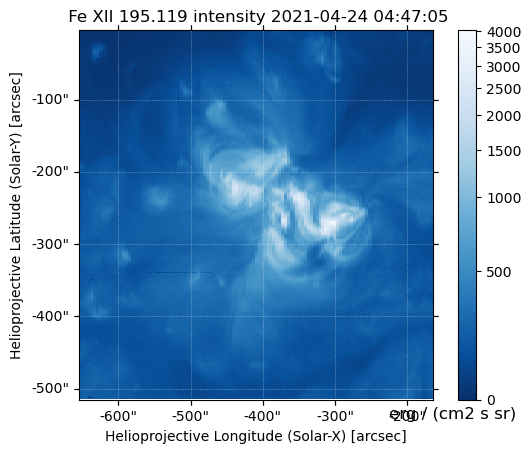

In [10]:
# Fit intensity (in a nice sunpy Map)
# Note: you can also load the exported FITS file using, eispac.EISMap(FILENAME)
inten_map = fit_res.get_map(component=0, measurement='intensity')
inten_map.peek()

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


Set MJD-BEG to 59328.176655 from DATE-BEG.
Set MJD-AVG to 59328.199363 from DATE-AVG.
Set MJD-END to 59328.222072 from DATE-END'. [astropy.wcs.wcs]


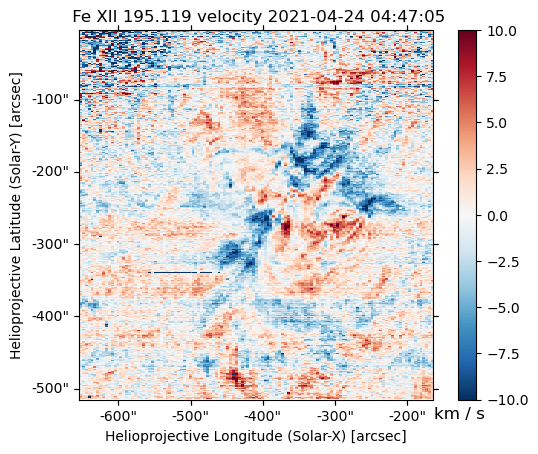

In [11]:
# Fit velocity map
# Note: You can also call .get_map() with just positional arguments and abbreviations
vel_map = fit_res.get_map(0, 'vel')
vel_map.peek()

# Links and Resources
Offical eispac github repo: https://github.com/USNavalResearchLaboratory/eispac

Documentation and User's Guide: https://eispac.readthedocs.io/en/latest/index.html
* Gives a lot more detail and a few more examples
* Also includes a (mostly) complete API reference

EIS level-1 HDF5 files: https://eis.nrl.navy.mil/ 
* Note: The server is currently having some certificate issues that we hope to resolve soon. Data can still be downloaded using eis_catalog

EIS Mapper online viewer: (https://eismapper.pyoung.org/)
* Great tool for quickly browsing context images